In [ ]:
%pip install cvxopt

Note: you may need to restart the kernel to use updated packages.


In [2]:
## =======================================================
## Import Key Packages
## =======================================================
## Standard Fare
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

## CVX Opt
import cvxopt
import cvxopt.solvers

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
## =======================================================
## Import and Manage the MNIST Data
## =======================================================
## Import the Data
mnist = loadmat('MNIST.mat')

## Create the test set
test_samples = mnist['test_samples'] #(n_test_sample, n_features)
test_samples_labels = mnist['test_samples_labels'] #(n_test_samples, 1)
print(f'Test data shape {test_samples.shape}; test data labels shape {test_samples_labels.shape}')

## Create the training set
train_samples = mnist['train_samples'] #(n_train_samples, n_features)
train_samples_labels = mnist['train_samples_labels'] #(n_train_samples, 1)
print(f'Test data shape {train_samples.shape}; test data labels shape {train_samples_labels.shape}')

print(f'Labels used:{np.unique(train_samples_labels)}') #display unique labels available for digits

Test data shape (1000, 784); test data labels shape (1000, 1)
Test data shape (4000, 784); test data labels shape (4000, 1)
Labels used:[0 1 2 3 4 5 6 7 8 9]



We first make code for training an SVM for binary classification with nonlinear kernels. 

\begin{equation*}
\begin{aligned}
& \text{maximize}
& & \tilde{L}(\mathbf{a}) = {1}^{\mathrm{T}}\mathbf{a} - \frac{1}{2} \mathbf{a}^{\mathrm{T}} \mathbf{T}\mathbf{K} \mathbf{T}\mathbf{a} \\
& \text{subject to}
& & {1}^{\mathrm{T}} \mathbf{a} \preceq C \\
& & & {1}^{\mathrm{T}} \mathbf{a} \succeq 0 \\
& & & \mathbf{a}^{\mathrm{T}} \mathbf{t} = 0
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
& \text{minimize}
& & \tilde{L}(\mathbf{a}) = \frac{1}{2} \mathbf{a}^{\mathrm{T}} \mathbf{T}\mathbf{K} \mathbf{T}\mathbf{a} - {1}^{\mathrm{T}}\mathbf{a} \\
& \text{subject to}
& & G \mathbf{a} \preceq h \\
& & & {\mathbf{t}}^{\mathrm{T}}\mathbf{a} = 0
\end{aligned}
\end{equation*}

where $G$ is an $N\times N$ identity matrix ontop of $-1$ times an $N\times N$ identity matrix and $h \in\mathbb{R}^{2N}$ where the first $N$ entries are $C$ and the second $N$ enties are $0$.


Secondly we develop code to predict the $\{-1,+1\}$ class for new data. 


In [ ]:
def nonlinear_kernel(X, Y, gamma):
  X = np.atleast_2d(X)
  Y = np.atleast_2d(Y)
  X_norm = np.sum(X**2, axis=1).reshape(-1,1)
  Y_norm = np.sum(Y**2,axis=1).reshape(1,-1)
  #getting squared euclidian distance matrix
  sq_dist = X_norm + Y_norm -2 * np.dot(X,Y.T)
  return np.exp(-gamma * sq_dist)


In [ ]:
class SVM(object):

  def __init__(self, kernel=nonlinear_kernel, C=1.0, gamma=0.05):
    
    self.kernel = kernel
    self.C = C
    self.gamma=gamma
    self.alphas = None #Lagrange Multipliers an
    self.sv_X = None #support Vects, traininng pts for when an > 0
    self.sv_Y = None #Labels corr to above
    self.b = 0.0

  def fit(self, X, y):
    """
    Fit the SVM model according to the given training data.
    
    We solve the dual formulation:
        
        max_α  L(α) = ∑ₙ αₙ - ½ ∑ₙ∑ₘ αₙ αₘ tₙ tₘ k(xₙ,xₘ)
          
        subject to (Equations 7.33 and 7.34):
          0 ≤ αₙ ≤ C,  and  ∑ₙ αₙ tₙ = 0.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features) or (n_samples, n_samples)
      Training vectors, where n_samples is the number of samples and n_features 
      is the number of features. For kernel=”precomputed”, the expected shape 
      of X is (n_samples, n_samples).

    y : array-like of shape (n_samples,)
      Target values (class labels in classification, real numbers in regression).

    Returns
    -------
    self : object
      Fitted estimator.
    """

    
    n_samples, n_features = X.shape
    
    K = self.kernel(X, X, gamma=self.gamma)
    
    #Constructing matrix P for the QP
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(-np.ones(n_samples))
    
    #Inequal Constraintts 
    G_std = cvxopt.matrix(np.diag(-np.ones(n_samples)))
    h_std = cvxopt.matrix(np.zeros(n_samples))
    
    G_slack = cvxopt.matrix(np.diag(np.ones(n_samples)))
    h_slack = cvxopt.matrix(np.ones(n_samples) * self.C)
    
    #Combine above 2 sets like Eq 7.33
    G = cvxopt.matrix(np.vstack((G_std, G_slack)))
    h = cvxopt.matrix(np.vstack((h_std, h_slack)))
    
    # Equality constraint: ∑ₙ αₙ tₙ = 0 (Equation 7.34).
    A = cvxopt.matrix(y.reshape(1,-1).astype('double'))
    b_eq = cvxopt.matrix(0.0)
    
    #Solv Quad programming 
    cvxopt.solvers.options['show_progress'] = False
    solution = cvxopt.solvers.qp(P,q,G,h,A,b_eq)
    alphas = np.ravel(solution['x'])
    
    #selecting supp vects indices where an >>>> 0
    sv = alphas>1e-5
    self.alphas = alphas[sv]
    self.sv_X = X[sv]
    self.sv_y = y[sv]
    
    # For any support vector x_i that satisfies 0 < αₙ < C, the KKT conditions (Equation 7.37)
    # require that t_i = ∑ⱼ αⱼ tⱼ k(x_j, x_i) + b.
    self.b = np.mean([sv_y_i - np.sum(self.alphas * self.sv_y *
                      self.kernel(self.sv_X, x.reshape(1,-1), gamma=self.gamma).flatten())
                      for x, sv_y_i in zip(self.sv_X, self.sv_y)])
    
    return self

  def predict(self, X):
    """
    Perform classification on samples in X.

    For an one-class model, +1 or -1 is returned.
    
    f(x) = ∑ₙ αₙ tₙ k(xₙ, x) + b   
          
    The sign of f(x) determines the predicted class (+1 or -1).

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features) or (n_samples_test, n_samples_train)

    Returns
    -------
    y_pred : ndarray of shape (n_samples,)
      Class labels for samples in X.
    """
    
    K = self.kernel(self.sv_X, X, gamma=self.gamma)
    decision = np.sum(self.alphas[:, None] * self.sv_y[:, None] * K, axis=0) +self.b
  
    return np.sign(decision)

  def score(self, X, y):
    """
    Return the mean accuracy on the given test data and labels. 

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
      Test samples.
    y : array-like of shape (n_samples,) or (n_samples, n_outputs)
      True labels for X.

    Return
    ------
    score : float
      Mean accuracy of self.predict(X)
    """
    y_pred = self.predict(X)
    return np.mean(y_pred == y)

In [6]:
#One vs Rest SVM
class OneVsRestSVM:
    def __init__(self, kernel=nonlinear_kernel, C=1.0, gamma=0.05):
        
        self.kernel=kernel
        self.C=C
        self.gamma=gamma
        self.classes = None 
        self.classifiers = {} #Dictionary will hold 1 SVM Classifier per class
        
    def fit(self, X, y):
        #This will train one SVM per class, and for each class k, label as +1 and
        #all other as -1
        
        self.classes = np.unique(y)
        for cls in self.classes:
            binary_y = np.where(y== cls, 1, -1)
            clf = SVM(kernel=self.kernel, C=self.C, gamma=self.gamma)
            clf.fit(X, binary_y)
            self.classifiers[cls] = clf
        return self
    
    def predict(self, X):
        #This predicts class label choosin classifier w highest decision score
        
        scores={}
        for cls, clf in self.classifiers.items():
            K = self.kernel(clf.sv_X, X, gamma=self.gamma)
            scores[cls] = np.sum(clf.alphas[:, None] * clf.sv_y[:, None]*K, axis=0) + clf.b
        n_samples = X.shape[0]
        preds = np.zeros(n_samples)
        for i in range(n_samples):
            sample_scores = {cls: scores[cls][i] for cls in self.classes}
            preds[i] = max(sample_scores, key = sample_scores.get)
        return preds
    
    def score(self, X, y):
        return np.mean(self.predict(X)==y)
                

In [7]:
#One vs One SVM
from itertools import combinations

class OneVsOneSVM:
    def __init__(self, kernel=nonlinear_kernel, C=1.0, gamma=0.05):
        self.kernel=kernel
        self.C=C 
        self.gamma=gamma
        self.classes = None
        self.classifiers = {}
        
    def fit(self, X, y):
        #Train SVM classifier for every pair of classes
        
        self.classes = np.unique(y)
        for cls1, cls2 in combinations(self.classes, 2):
            idx = np.where((y==cls1) | (y==cls2))[0]
            X_pair = X[idx]
            y_pair = y[idx]
            binary_y = np.where(y_pair == cls1, 1, -1)
            clf = SVM(kernel=self.kernel, C=self.C, gamma=self.gamma)
            clf.fit(X_pair, binary_y)
            self.classifiers[(cls1,cls2)] = clf
        return self
    
    def predict(self, X):
        
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        votes = np.zeros((n_samples, n_classes))
        
        for(cls1, cls2), clf in self.classifiers.items():
            pred = clf.predict(X)
            col1 = np.where(self.classes == cls1)[0][0]
            col2 = np.where(self.classes == cls2)[0][0]
            votes[:, col1] += (pred==1).astype(int)
            votes[:, col2] += (pred==-1).astype(int)
        
        final_pred = self.classes[np.argmax(votes, axis=1)]
        return final_pred
        
        #Old Version below yielded horrible accuracy in the 20% range
        """
        votes = {cls: np.zeros(X.shape[0]) for cls in self.classes}
        for (cls1,cls2), clf in self.classifiers.items():
            K = self.kernel(clf.sv_X, X, gamma=self.gamma)
            decision = np.sum(clf.alphas[:, None] * clf.sv_y[:, None] * K, axis=0) + clf.b
            for i, d in enumerate(decision):
                if d>0:
                    votes[cls1][i] +=1
                else:
                    votes[cls2][i] +=1
            n_samples = X.shape[0]
            preds = np.zeros(n_samples)
            for i in range(n_samples):
                sample_votes = {cls: votes[cls][i] for cls in self.classes}
                preds[i] = max(sample_votes, key = sample_votes.get)
            return preds
        """
        
    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)
        

In [8]:
#Tester for both SVM
y_train = train_samples_labels.flatten()
y_test = test_samples_labels.flatten()

#1vRest
ovr = OneVsRestSVM(kernel=nonlinear_kernel, C=1.0, gamma=0.05)
ovr.fit(train_samples, y_train)
print("One Vs Rest training accuracy:", ovr.score(train_samples, y_train))
print("One Vs Rest Test Accuracy:", ovr.score(test_samples, y_test))

#1v1
ovo = OneVsOneSVM(kernel = nonlinear_kernel, C=1.0, gamma=0.05)
ovo.fit(train_samples, y_train)
print("One Vs One training accuracy:", ovo.score(train_samples, y_train))
print("One Vs One test accuracy:", ovo.score(test_samples, y_test))

One Vs Rest training accuracy: 0.88075
One Vs Rest Test Accuracy: 0.847
One Vs One training accuracy: 0.89825
One Vs One test accuracy: 0.872


The parameter $C>0$ controls the tradeoff between the size of the margin and the slack variable penalty. It is analogous to the inverse of a regularization coefficient. Include in your report a brief discussion of how you found an appropriate value.

In [9]:
#Hyperparameter tuning
import itertools

"""
C_values = np.logspace(-3, 3, num=7)  
C = 0.0010, Test Accuracy = 0.2060
C = 0.0100, Test Accuracy = 0.6800
C = 0.1000, Test Accuracy = 0.8230
C = 1.0000, Test Accuracy = 0.8470
C = 10.0000, Test Accuracy = 0.8870
C = 100.0000, Test Accuracy = 0.9080
C = 1000.0000, Test Accuracy = 0.9000
Best C found: 100.0 with test accuracy: 0.908
"""
C_fixed=100.0
gamma_values = np.logspace(-3, 1, num=5)
best_accuracy = 0

"""
for gamma in gamma_values:
    model = OneVsRestSVM(kernel=nonlinear_kernel, C=C_fixed, gamma=gamma)
    model.fit(train_samples, y_train)
    acc = model.score(test_samples, y_test)
    print(f"C = {C_fixed:.4f}, gamma = {gamma:.4f}, Test Accuracy = {acc:.4f}")
    if acc > best_accuracy:
        best_accuracy = acc
        best_accuracy = acc
        best_gamma = gamma
C = 100.0000, gamma = 0.0010, Test Accuracy = 0.8550
C = 100.0000, gamma = 0.0100, Test Accuracy = 0.8920
C = 100.0000, gamma = 0.1000, Test Accuracy = 0.9210
"""
best_gamma = 0.1

One-vs-Rest Confusion Matrix:
[[ 80   0   1   1   0   2   1   0   0   1]
 [  0 121   0   0   0   0   0   0   1   0]
 [  0   0 103   0   0   0   1   2   6   1]
 [  0   0   0 103   0   6   2   2   1   1]
 [  0   0   0   0  98   0   5   0   1   4]
 [  1   0   0   3   0  83   1   0   4   0]
 [  2   0   0   0   0   2  81   1   1   0]
 [  2   1   2   0   1   0   0  93   0   0]
 [  0   0   2   3   4   1   0   0  75   1]
 [  0   1   0   1   2   0   0   1   3  84]]


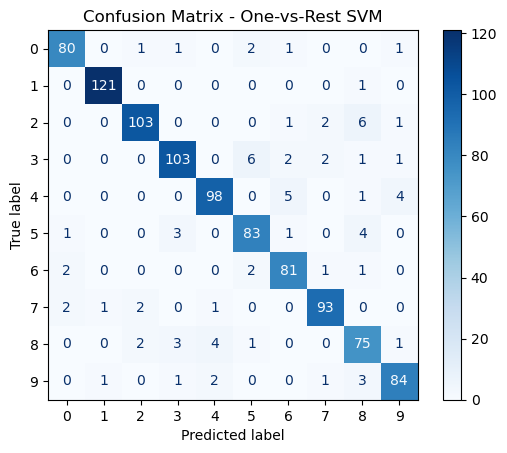

One-vs-One Confusion Matrix:
[[ 85   0   0   0   0   0   1   0   0   0]
 [  0 121   0   0   0   0   0   0   1   0]
 [  0   0 107   2   0   0   0   2   1   1]
 [  0   1   1 100   0   8   1   3   1   0]
 [  0   0   1   0  99   0   3   0   0   5]
 [  1   0   0   4   1  83   1   0   2   0]
 [  3   0   2   0   1   1  80   0   0   0]
 [  0   1   3   2   2   0   0  89   1   1]
 [  1   0   3   4   2   0   0   3  72   1]
 [  0   0   0   0   1   0   0   4   1  86]]


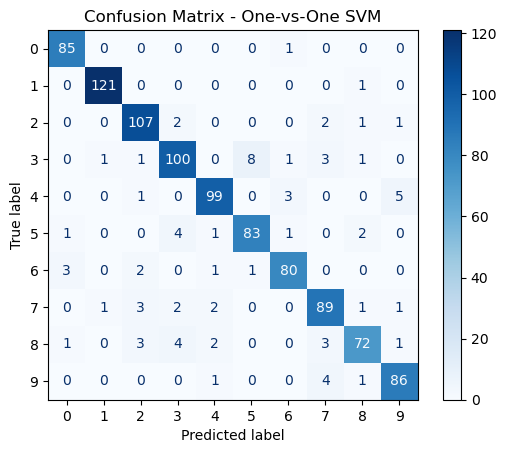

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#1 v rest
ovr_model = OneVsRestSVM(kernel=nonlinear_kernel, C=C_fixed, gamma=best_gamma)
ovr_model.fit(train_samples, y_train)
ovr_predictions = ovr_model.predict(test_samples)

cm_ovr = confusion_matrix(y_test, ovr_predictions)
print("One-vs-Rest Confusion Matrix:")
print(cm_ovr)

disp_ovr = ConfusionMatrixDisplay(confusion_matrix=cm_ovr)
disp_ovr.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - One-vs-Rest SVM")
plt.show()

#1 v 1
ovo_model = OneVsOneSVM(kernel=nonlinear_kernel, C=C_fixed, gamma=best_gamma)
ovo_model.fit(train_samples, y_train)
ovo_predictions = ovo_model.predict(test_samples)

cm_ovo = confusion_matrix(y_test, ovo_predictions)
print("One-vs-One Confusion Matrix:")
print(cm_ovo)

disp_ovo = ConfusionMatrixDisplay(confusion_matrix=cm_ovo)
disp_ovo.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - One-vs-One SVM")
plt.show()
